# Functional enrichment of biological terms

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by assigning them to biological terms from prior knowledge.

In this notebook we showcase how to use `decoupler` for functional enrichment with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc
import numpy as np

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


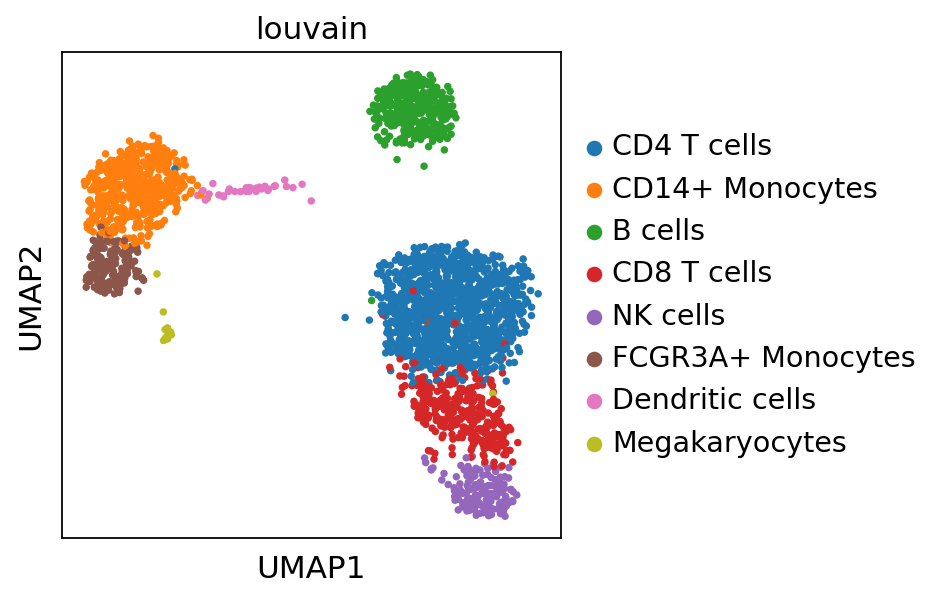

In [3]:
sc.pl.umap(adata, color='louvain')

## MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [4]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


As an example, we will use the hallmark gene sets, but we could have used any other such as KEGG or REACTOME. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [5]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,HALLMARK_IL2_STAT5_SIGNALING
250,MAFF,hallmark,HALLMARK_COAGULATION
270,MAFF,hallmark,HALLMARK_HYPOXIA
373,MAFF,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,HALLMARK_COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450526,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS


For this example we will use the resource MSigDB, but we could have used any other such as GO. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

## Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [6]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 50 sources.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:02<00:00, 916.53it/s]


The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [7]:
adata.obsm['ora_estimate']

source,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
AAACATACAACCAC-1,1.307006,10.029702,0.822139,0.389675,1.670031,0.650245,2.441094,0.337563,0.805206,0.032740,...,0.733962,2.286568,0.354931,2.986336,8.270970,6.424740,0.586324,1.983873,0.164805,0.080157
AAACATTGAGCTAC-1,1.307006,14.824231,2.152116,0.389675,2.104104,-0.000000,0.442704,0.337563,0.457516,0.321093,...,2.496213,1.659624,1.015676,1.659624,3.053600,2.578916,0.346751,0.871448,0.503794,0.080157
AAACATTGATCAGC-1,3.893118,7.893567,3.312021,0.389675,3.095283,0.650245,5.115631,0.976973,0.805206,0.321093,...,1.087271,3.752012,0.037885,1.114303,7.597478,2.075696,0.888675,4.038435,0.164805,1.087420
AAACCGTGCTTCCG-1,5.591584,7.893567,2.152116,1.036748,1.670031,-0.000000,2.911700,0.143019,1.747025,0.591452,...,1.501986,3.752012,0.354931,1.659624,5.709134,5.000056,0.346751,1.567924,0.164805,1.087420
AAACCGTGTATGCG-1,0.999733,10.029702,2.707608,1.871866,1.670031,1.948869,0.666121,0.337563,0.805206,0.591452,...,1.973108,1.659624,0.151790,1.114303,1.803915,1.212284,0.586324,0.375221,0.164805,0.179270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,3.382339,9.297059,1.204403,1.036748,2.580035,0.224257,10.804691,0.143019,2.324194,1.359530,...,3.683543,3.752012,0.151790,2.286568,5.709134,2.075696,0.586324,4.639190,0.164805,1.087420
TTTCTACTGAGGCA-1,6.851412,4.777953,6.964458,1.036748,1.670031,0.650245,2.006126,0.035215,0.457516,1.359530,...,3.683543,1.659624,0.151790,2.286568,2.188676,8.792837,0.172992,2.441252,0.164805,0.080157
TTTCTACTTCCTCG-1,1.652714,7.224005,2.152116,-0.000000,1.670031,1.235034,2.441094,0.337563,1.238111,0.134773,...,1.087271,0.661862,0.151790,1.659624,8.965328,3.125529,0.064563,4.639190,-0.000000,0.329247
TTTGCATGAGAGGC-1,2.034900,5.352930,1.204403,1.036748,0.939005,1.235034,0.267770,0.617706,0.805206,0.134773,...,0.733962,2.286568,0.151790,0.661862,3.530830,5.696068,0.346751,2.441252,0.164805,0.329247


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

/home/badi/miniconda3/envs/dcp39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


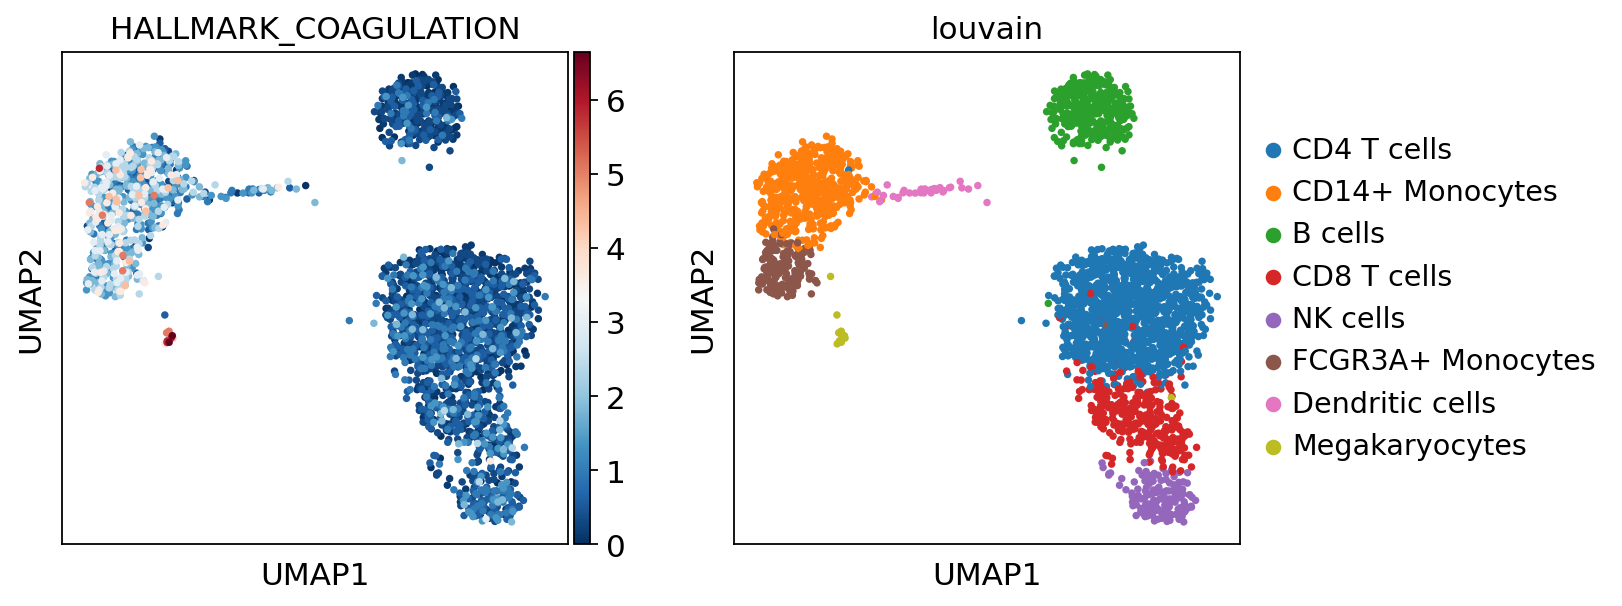

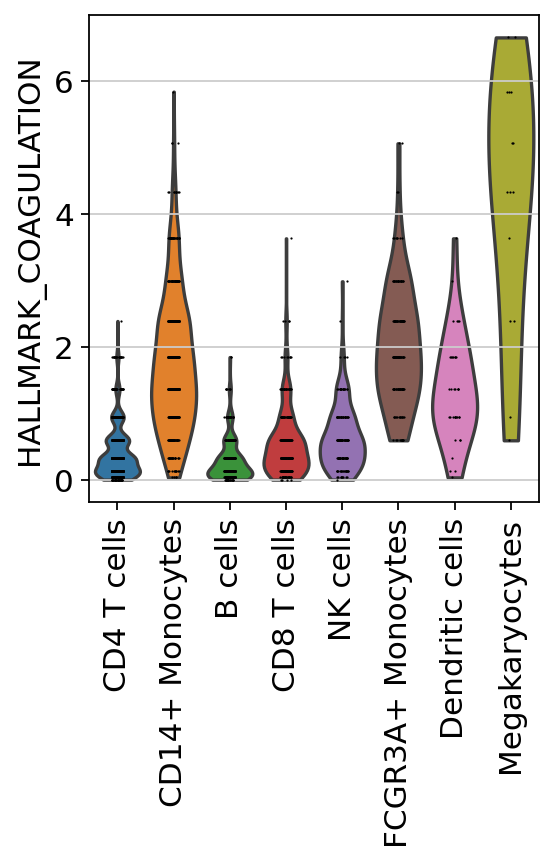

In [9]:
sc.pl.umap(acts, color=['HALLMARK_COAGULATION', 'louvain'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['HALLMARK_COAGULATION'], groupby='louvain', rotation=90)

The cells highlighted seem to be enriched by coagulation.

## Exploration

Let's identify which are the top gene sets per cell type. We can do it by using the function `dc.rank_sources_groups`, which identifies marker gene sets using the same statistical tests available in scanpy's `scanpy.tl.rank_genes_groups`.

In [10]:
df = dc.rank_sources_groups(acts, groupby='louvain', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,HALLMARK_KRAS_SIGNALING_DN,8.300668,0.171902,6.620000e-16,3.009091e-15
1,B cells,rest,HALLMARK_HEDGEHOG_SIGNALING,2.108226,0.027850,3.538195e-02,5.528430e-02
2,B cells,rest,HALLMARK_MYOGENESIS,1.896726,0.074938,5.829358e-02,8.327655e-02
3,B cells,rest,HALLMARK_ALLOGRAFT_REJECTION,0.968864,0.204067,3.329577e-01,4.161971e-01
4,B cells,rest,HALLMARK_SPERMATOGENESIS,0.521071,0.009809,6.024869e-01,6.846442e-01
...,...,...,...,...,...,...,...
395,NK cells,rest,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,-3.210821,-0.487032,1.466372e-03,6.109882e-03
396,NK cells,rest,HALLMARK_UV_RESPONSE_UP,-3.215664,-0.479964,1.447535e-03,6.109882e-03
397,NK cells,rest,HALLMARK_ANGIOGENESIS,-3.911384,-0.256110,1.214908e-04,8.677915e-04
398,NK cells,rest,HALLMARK_IL6_JAK_STAT3_SIGNALING,-4.133565,-0.324985,4.637187e-05,3.864322e-04


We can then extract the top 3 markers per cell type:

In [11]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'B cells': ['HALLMARK_KRAS_SIGNALING_DN',
  'HALLMARK_HEDGEHOG_SIGNALING',
  'HALLMARK_MYOGENESIS'],
 'CD14+ Monocytes': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'],
 'CD4 T cells': ['HALLMARK_WNT_BETA_CATENIN_SIGNALING',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_MYC_TARGETS_V2'],
 'CD8 T cells': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_MYC_TARGETS_V2',
  'HALLMARK_PI3K_AKT_MTOR_SIGNALING'],
 'Dendritic cells': ['HALLMARK_OXIDATIVE_PHOSPHORYLATION',
  'HALLMARK_MYC_TARGETS_V1',
  'HALLMARK_ALLOGRAFT_REJECTION'],
 'FCGR3A+ Monocytes': ['HALLMARK_COMPLEMENT',
  'HALLMARK_COAGULATION',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE'],
 'Megakaryocytes': ['HALLMARK_COAGULATION',
  'HALLMARK_ANGIOGENESIS',
  'HALLMARK_MYOGENESIS'],
 'NK cells': ['HALLMARK_ALLOGRAFT_REJECTION',
  'HALLMARK_INTERFERON_GAMMA_RESPONSE',
  'HALLMARK_INTERFERON_ALPHA_RESPONSE']}

We can plot the obtained markers:

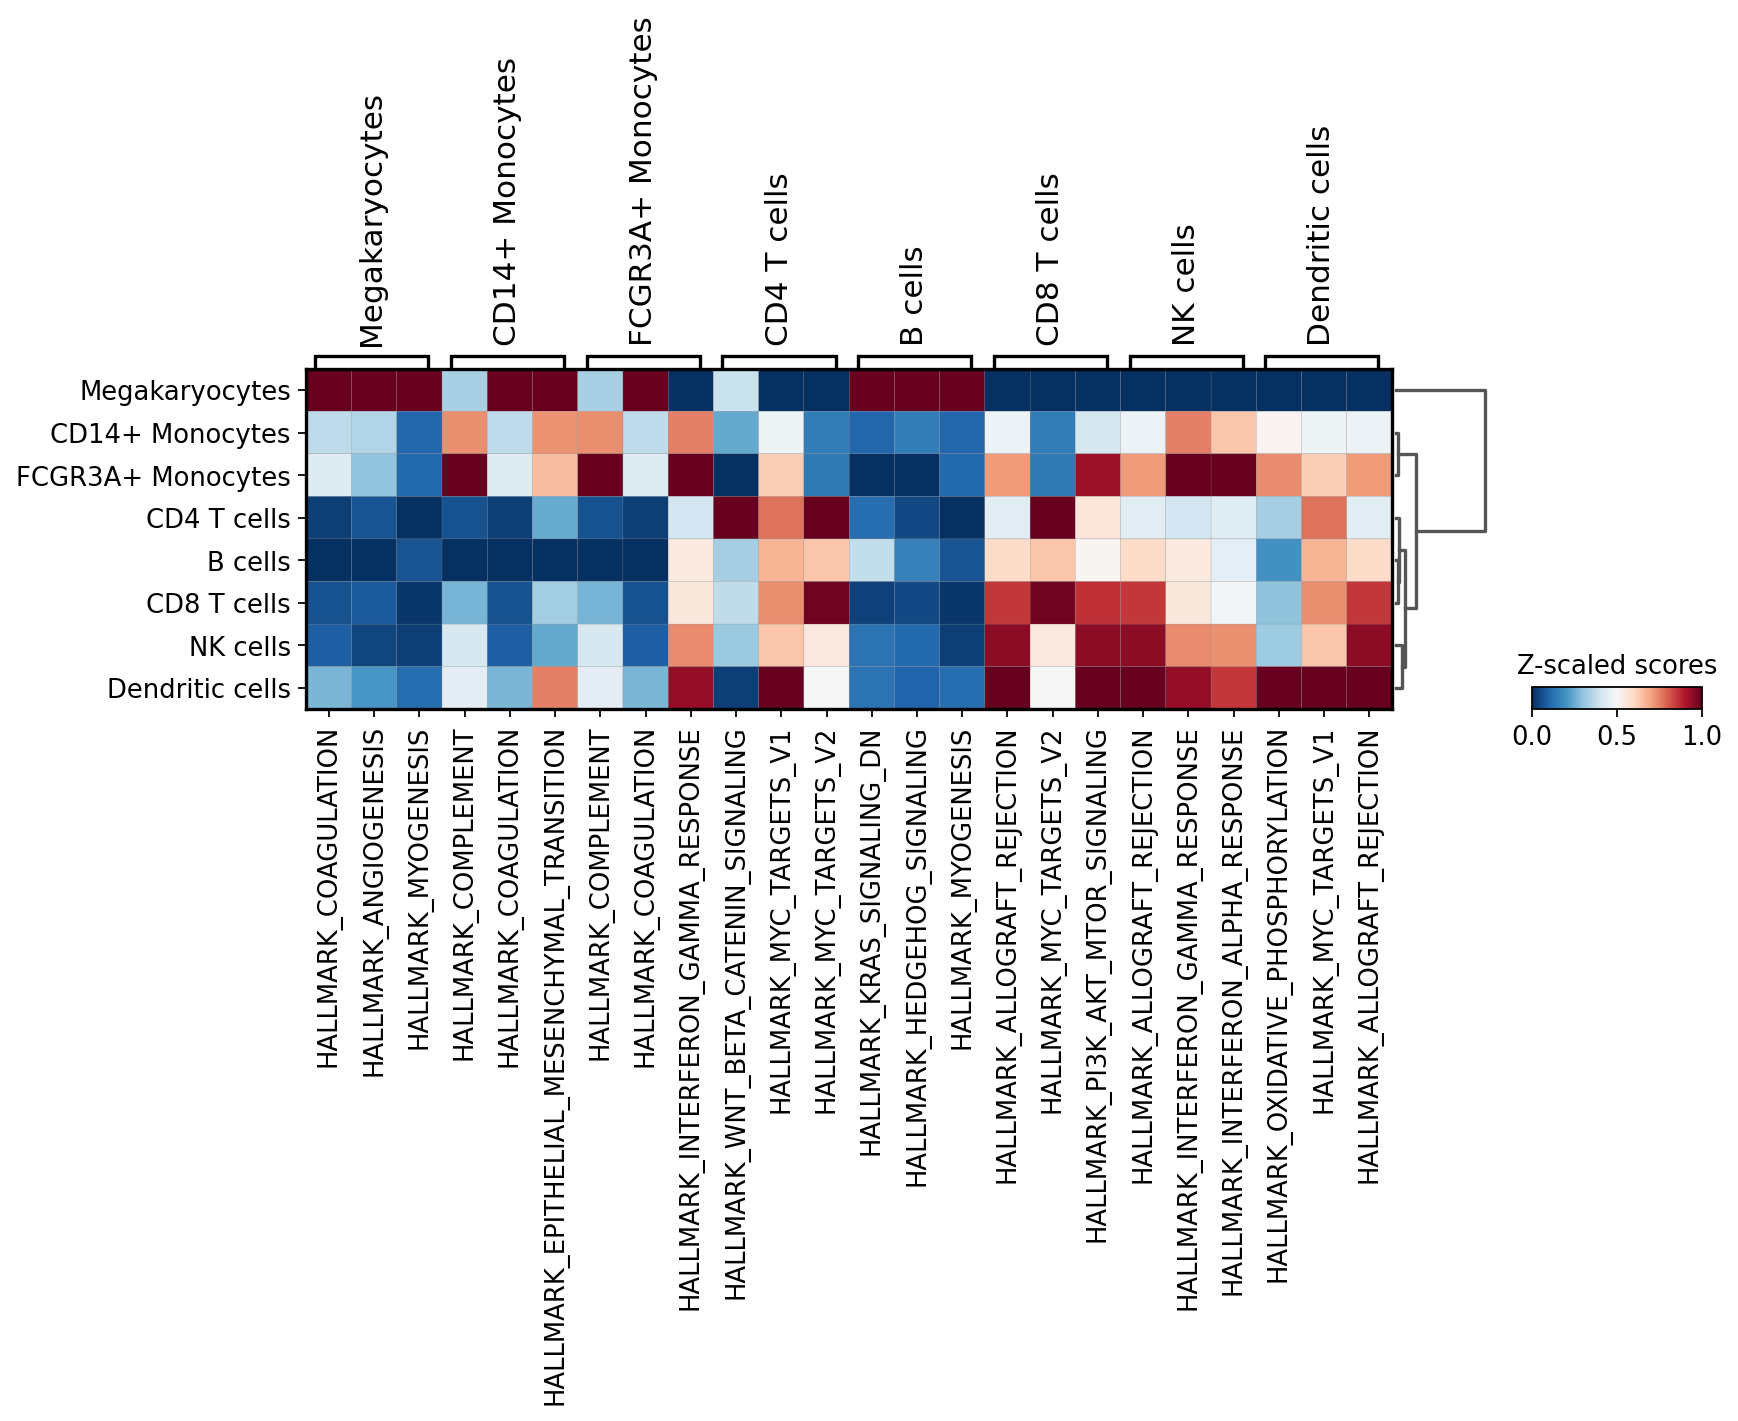

In [12]:
sc.pl.matrixplot(acts, source_markers, 'louvain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In this specific example, we can observe that myeloid cell types are enriched by the complement's system genes and megakaryocytes are enriched by coagulation genes.

<div class="alert alert-info">

**Note**
    
If your data consist of different conditions with enough samples, we recommend to work with pseudo-bulk profiles instead. Check this
[vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more informatin.

</div>